<a href="https://colab.research.google.com/github/Sharanya-Parimanoharan/AI-Generated-Text-Detection/blob/main/BERT_N_gram.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from transformers import BertTokenizer, BertModel, AdamW
import torch
from torch.utils.data import DataLoader, TensorDataset
from tqdm import tqdm
import random
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, roc_auc_score, balanced_accuracy_score,classification_report
import matplotlib.pyplot as plt


In [ ]:
# Set random seeds for reproducibility
seed = 42
random.seed(seed)
np.random.seed(seed)
torch.manual_seed(seed)
if torch.cuda.is_available():
       torch.cuda.manual_seed_all(seed)

In [ ]:
# Training parameters
num_epochs = 5
learning_rate = 2e-5

loss_fn = torch.nn.CrossEntropyLoss()


In [ ]:
# Load your dataset
df = pd.read_csv("drive/MyDrive/data_2.csv")

# Data preprocessing
df['text'] = df['text'].str.lower()
df["label_int"] = np.where(df["label"] == '"AI"', 1, 0)
df['label_int'] = df['label_int'].astype(int)

In [ ]:
# Split data into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


In [ ]:
# Load pre-trained BERT model and tokenizer
model_name = 'bert-base-uncased'
tokenizer = BertTokenizer.from_pretrained(model_name)
model = BertModel.from_pretrained(model_name)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

In [ ]:
# Tokenize and prepare data as DataLoader
max_seq_length = 128
batch_size = 12

train_encodings = tokenizer(list(train_df['text']), truncation=True, padding=True, max_length=max_seq_length, return_tensors='pt')
test_encodings = tokenizer(list(test_df['text']), truncation=True, padding=True, max_length=max_seq_length, return_tensors='pt')


In [ ]:
# Extract n-gram features
vectorizer = CountVectorizer(ngram_range=(1, 4))
train_ngram_features = vectorizer.fit_transform(train_df['text']).toarray()
test_ngram_features = vectorizer.transform(test_df['text']).toarray()


In [ ]:
first_sentence_ngram_features = vectorizer.fit_transform([train_df['text'].iloc[0]]).toarray()

# Display the features in a DataFrame for better visibility
feature_names = vectorizer.get_feature_names_out()
first_sentence_ngram_df = pd.DataFrame(first_sentence_ngram_features, columns=feature_names)

# Print the DataFrame for the first sentence
print(first_sentence_ngram_df)

   acceleration  acceleration responses  acceleration responses and  \
0             3                       3                           1   

   acceleration responses and track  acceleration responses from  \
0                                 1                            1   

   acceleration responses from passenger  acceleration responses the  \
0                                      1                           1   

   acceleration responses the proposed  accelerometer  accelerometer and  ...  \
0                                    1              1                  1  ...   

   via gps data  via gps data landmarks  while  while capturing  \
0             1                       1      1                1   

   while capturing acceleration  while capturing acceleration responses  with  \
0                             1                                       1     1   

   with its  with its prototype  with its prototype implementation  
0         1                   1              

In [ ]:

# Convert n-gram features to PyTorch tensors
train_ngram_tensors = torch.tensor(train_ngram_features, dtype=torch.float32)
test_ngram_tensors = torch.tensor(test_ngram_features, dtype=torch.float32)

train_input_ids = train_encodings.input_ids
train_attention_mask = train_encodings.attention_mask


In [ ]:
# Ensure the n-gram features have the same sequence length as BERT
train_ngram_tensors = train_ngram_tensors[:, :max_seq_length]

# Append n-gram features to input tensors
train_input_ids = torch.cat([train_input_ids, train_ngram_tensors], dim=1).long()


In [ ]:

# Create a custom model that combines BERT embeddings and n-gram features
class CustomModel(torch.nn.Module):
    def __init__(self, bert_model, ngram_input_size, num_labels):
        super(CustomModel, self).__init__()
        self.bert = bert_model
        self.linear = torch.nn.Linear(bert_model.config.hidden_size + ngram_input_size, num_labels)

    def forward(self, input_ids, attention_mask, ngram_features):
        bert_outputs = self.bert(input_ids, attention_mask=attention_mask)
        pooled_output = bert_outputs.pooler_output
        combined_features = torch.cat([pooled_output, ngram_features], dim=1)
        logits = self.linear(combined_features)
        return logits


In [ ]:
# Instantiate your custom model
num_labels = 2  # assuming binary classification

custom_model = CustomModel(model, ngram_input_size=train_ngram_tensors.shape[1], num_labels=num_labels)

optimizer = AdamW(custom_model.parameters(), lr=learning_rate)

/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:588: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [ ]:
# Tokenize and prepare test data
test_input_ids = test_encodings.input_ids
test_attention_mask = test_encodings.attention_mask
test_ngram_tensors = test_ngram_tensors[:, :max_seq_length]
test_input_ids = torch.cat([test_input_ids, test_ngram_tensors], dim=1).long()

train_attention_mask = torch.cat([train_attention_mask, torch.ones_like(train_ngram_tensors)], dim=1)
test_attention_mask = torch.cat([test_attention_mask, torch.ones_like(test_ngram_tensors)], dim=1)


In [ ]:
# Convert to PyTorch DataLoader
train_labels = torch.tensor(list(train_df['label_int']), dtype=torch.long)
test_labels = torch.tensor(list(test_df['label_int']), dtype=torch.long)

train_dataset = TensorDataset(train_input_ids, train_attention_mask, train_labels)
test_dataset = TensorDataset(test_input_ids, test_attention_mask, test_labels)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size)

In [ ]:
train_loss_values = []


# Training loop
for epoch in range(num_epochs):
    custom_model.train()
    train_loss = 0.0
    for batch in tqdm(train_dataloader, desc=f'Epoch {epoch + 1}'):
        optimizer.zero_grad()
        input_ids, attention_mask, labels = batch
        ngram_features = input_ids[:, -train_ngram_tensors.shape[1]:]  # Extract n-gram features
        logits = custom_model(input_ids, attention_mask=attention_mask, ngram_features=ngram_features)
        loss = loss_fn(logits, labels)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
        torch.cuda.empty_cache()


    avg_train_loss = train_loss / len(train_dataloader)
    train_loss_values.append(avg_train_loss)

    print(f'Epoch {epoch + 1} - Avg. Training Loss: {avg_train_loss}')

Epoch 1:   0%|          | 0/34 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [ ]:
# Plotting the training loss graph
plt.plot(range(1, num_epochs + 1), train_loss_values, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.show()
# Save the trained model
torch.save(custom_model.state_dict(), 'custom_model.pth')
torch.save(custom_model.state_dict(), '/content/drive/MyDrive/custom_model.pth')

print(f"Length of train_loss_values: {len(train_loss_values)}")


NameError: name 'train_loss_values' is not defined

In [ ]:
# Evaluation
custom_model.eval()
eval_loss = 0.0
predictions = []
true_labels = []

with torch.no_grad():
    for batch in tqdm(test_dataloader, desc='Evaluating'):
        input_ids, attention_mask, labels = batch
        ngram_features = input_ids[:, -test_ngram_tensors.shape[1]:]  # Extract n-gram features
        logits = custom_model(input_ids, attention_mask=attention_mask, ngram_features=ngram_features)
        loss = loss_fn(logits, labels)
        eval_loss += loss.item()
        predictions.extend(logits.argmax(dim=1).tolist())
        true_labels.extend(labels.tolist())

# Calculate evaluation metrics
accuracy = accuracy_score(true_labels, predictions)
auc_score = roc_auc_score(true_labels, predictions)
balanced_accuracy = balanced_accuracy_score(true_labels, predictions)
report = classification_report(true_labels, predictions)

print(f'Accuracy: {accuracy}')
print(f'AUC: {auc_score}')
print(f'Balanced Accuracy: {balanced_accuracy}')
print("Classification Report:\n", report)

Evaluating:  22%|██▏       | 2/9 [00:56<03:16, 28.13s/it]


KeyboardInterrupt: 

In [ ]:


new_test_df=pd.read_csv("drive/MyDrive/test.csv")
# Data preprocessing
new_test_df['text'] = new_test_df['text'].str.lower()
new_test_df["label_int"] = np.where(new_test_df["label"] == '"AI"', 1, 0)
new_test_df['label_int'] = new_test_df['label_int'].astype(int)
new_test_labels = new_test_df['label_int'].tolist()

# Assuming you've already defined your model architecture
# with the CustomModel class and initialized it with the correct parameters.

# Create an instance of the CustomModel
loaded_model = CustomModel(model, ngram_input_size=train_ngram_tensors.shape[1], num_labels=num_labels)

# Load the saved model state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/custom_model.pth'))

# Set the model to evaluation mode
loaded_model.eval()

# Now, you can use the loaded_model for making predictions on new data

# For example, assuming you have a new test dataset named 'new_test_df'
# Perform the necessary preprocessing, tokenization, and feature extraction on 'new_test_df'

# Combine BERT Input and N-gram Features
new_test_encodings = tokenizer(list(new_test_df['text']), truncation=True, padding=True, max_length=max_seq_length, return_tensors='pt')
new_test_ngram_features = vectorizer.transform(new_test_df['text']).toarray()
new_test_ngram_tensors = torch.tensor(new_test_ngram_features, dtype=torch.float32)



print(new_test_encodings.input_ids.size())
print(new_test_encodings.attention_mask.size())
print(test_labels.size())




new_test_input_ids = torch.cat([new_test_encodings.input_ids, new_test_ngram_tensors[:, :max_seq_length]], dim=1).long()

new_test_attention_mask = torch.cat([new_test_encodings.attention_mask, torch.ones_like(new_test_ngram_tensors)], dim=1)
new_test_input_ids = new_test_input_ids[:, :max_seq_length]
new_test_attention_mask = new_test_attention_mask[:, :max_seq_length]

new_test_labels = torch.tensor(list(new_test_df['label_int']), dtype=torch.long)
new_test_dataset = TensorDataset(new_test_encodings.input_ids, new_test_encodings.attention_mask, new_test_labels)

new_test_dataloader = DataLoader(new_test_dataset, batch_size=batch_size)


### Model Inference
##with torch.no_grad():
##    logits = loaded_model(new_test_input_ids, attention_mask=new_test_attention_mask, ngram_features=new_test_ngram_tensors)
##    predictions = logits.argmax(dim=1).tolist()
predictions = []
true_labels = []


with torch.no_grad():
    for batch in tqdm(new_test_dataloader, desc='Evaluating'):
        input_ids, attention_mask, labels = batch
        ngram_features = input_ids[:, -test_ngram_tensors.shape[1]:]  # Extract n-gram features
        logits = custom_model(input_ids, attention_mask=attention_mask, ngram_features=ngram_features)
        predictions.extend(logits.argmax(dim=1).tolist())
        true_labels.extend(labels.tolist())

# Now 'predictions' contains the predicted labels for the new test data
# Calculate accuracy
print(predictions)
print(true_labels)

accuracy = accuracy_score(true_labels, predictions)

print(f'Accuracy on the new test data: {accuracy}')


# Print some text, true labels, and predictions
for i in range(min(7, len(new_test_labels))):  # Print the first 5 samples
    print(f"Text: {new_test_df['text'].iloc[i]}")
    print(f"True Label: {new_test_labels[i]}, Predicted Label: {predictions[i]}")
    print("="*50)


torch.Size([59, 128])
torch.Size([59, 128])
torch.Size([100])


Evaluating: 100%|██████████| 5/5 [00:22<00:00,  4.49s/it]

[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1]
[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1]
Accuracy on the new test data: 0.6271186440677966
Text: this paper discusses the architecture, protocol standards, and the design strategy of network systems in the cim environment. the first part describes problems in standardizing communication protocols, analyses communication attributes in the cim environment, and explains our strategies. the second part presents the design of the cims/erc network system and its traffic statistics.

True Label: 0, Predicted Label: 1
Text: in the ephemeral dance of cosmic energies, the symphony of existence unfolds across the tapestry of space and time. vibrant hues of possibility intermingle with th

In [ ]:
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score,classification_report,recall_score,f1_score, confusion_matrix

new_test_df=pd.read_csv("drive/MyDrive/test_new.csv")
# Data preprocessing
new_test_df['text'] = new_test_df['text'].str.lower()
new_test_df["label_int"] = np.where(new_test_df["label"] == '"AI"', 1, 0)
new_test_df['label_int'] = new_test_df['label_int'].astype(int)
new_test_labels = new_test_df['label_int'].tolist()

# Assuming you've already defined your model architecture
# with the CustomModel class and initialized it with the correct parameters.

# Create an instance of the CustomModel
loaded_model = CustomModel(model, ngram_input_size=train_ngram_tensors.shape[1], num_labels=num_labels)

# Load the saved model state dictionary
loaded_model.load_state_dict(torch.load('/content/drive/MyDrive/custom_model.pth'))

# Set the model to evaluation mode
loaded_model.eval()

# Now, you can use the loaded_model for making predictions on new data

# For example, assuming you have a new test dataset named 'new_test_df'
# Perform the necessary preprocessing, tokenization, and feature extraction on 'new_test_df'

# Combine BERT Input and N-gram Features
new_test_encodings = tokenizer(list(new_test_df['text']), truncation=True, padding=True, max_length=max_seq_length, return_tensors='pt')
new_test_ngram_features = vectorizer.transform(new_test_df['text']).toarray()
new_test_ngram_tensors = torch.tensor(new_test_ngram_features, dtype=torch.float32)



print(new_test_encodings.input_ids.size())
print(new_test_encodings.attention_mask.size())
print(test_labels.size())




new_test_input_ids = torch.cat([new_test_encodings.input_ids, new_test_ngram_tensors[:, :max_seq_length]], dim=1).long()

new_test_attention_mask = torch.cat([new_test_encodings.attention_mask, torch.ones_like(new_test_ngram_tensors)], dim=1)
new_test_input_ids = new_test_input_ids[:, :max_seq_length]
new_test_attention_mask = new_test_attention_mask[:, :max_seq_length]

new_test_labels = torch.tensor(list(new_test_df['label_int']), dtype=torch.long)
new_test_dataset = TensorDataset(new_test_encodings.input_ids, new_test_encodings.attention_mask, new_test_labels)

new_test_dataloader = DataLoader(new_test_dataset, batch_size=batch_size)


### Model Inference
##with torch.no_grad():
##    logits = loaded_model(new_test_input_ids, attention_mask=new_test_attention_mask, ngram_features=new_test_ngram_tensors)
##    predictions = logits.argmax(dim=1).tolist()
predictions = []
true_labels = []


with torch.no_grad():
    for batch in tqdm(new_test_dataloader, desc='Evaluating'):
        input_ids, attention_mask, labels = batch
        ngram_features = input_ids[:, -test_ngram_tensors.shape[1]:]  # Extract n-gram features
        logits = custom_model(input_ids, attention_mask=attention_mask, ngram_features=ngram_features)
        predictions.extend(logits.argmax(dim=1).tolist())
        true_labels.extend(labels.tolist())

# Now 'predictions' contains the predicted labels for the new test data
# Calculate accuracy
print(predictions)
print(true_labels)

np.savetxt('/content/drive/MyDrive/pred_BERTNgram.csv', predictions, delimiter=',',  fmt='%.2f')


accuracy = accuracy_score(true_labels, predictions)
precision_ai = precision_score(true_labels, predictions , pos_label=1)  # Assuming "AI" is the positive class
precision_human = precision_score(true_labels, predictions, pos_label=0)  # Assuming "AI" is the positive class

recall_ai = recall_score(true_labels, predictions, pos_label=1)  # Assuming "AI" is the positive class
recall_human = recall_score(true_labels, predictions, pos_label=0)  # Assuming "AI" is the positive class

f1_ai = f1_score(true_labels, predictions, pos_label=1)  # Assuming "AI" is the positive class
f1_human = f1_score(true_labels, predictions, pos_label=0)  # Assuming "AI" is the positive class
conf_matrix = confusion_matrix(true_labels, predictions)


print(f'Accuracy on the new test data: {accuracy}')
print("Precision:", precision_ai)
print("Precision:", precision_human)

print("Recall:", recall_ai)
print("Recall:", recall_human)

print("F1-Score:", f1_ai)
print("F1-Score:", f1_human)

# Print some text, true labels, and predictions
for i in range(min(7, len(new_test_labels))):  # Print the first 5 samples
    print(f"Text: {new_test_df['text'].iloc[i]}")
    print(f"True Label: {new_test_labels[i]}, Predicted Label: {predictions[i]}")
    print("="*50)


torch.Size([199, 128])
torch.Size([199, 128])
torch.Size([100])


Evaluating: 100%|██████████| 17/17 [01:20<00:00,  4.71s/it]


[1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 1, 1, 0]
[0, 1, 0, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 0,

TypeError: Axes.bar() got multiple values for argument 'width'

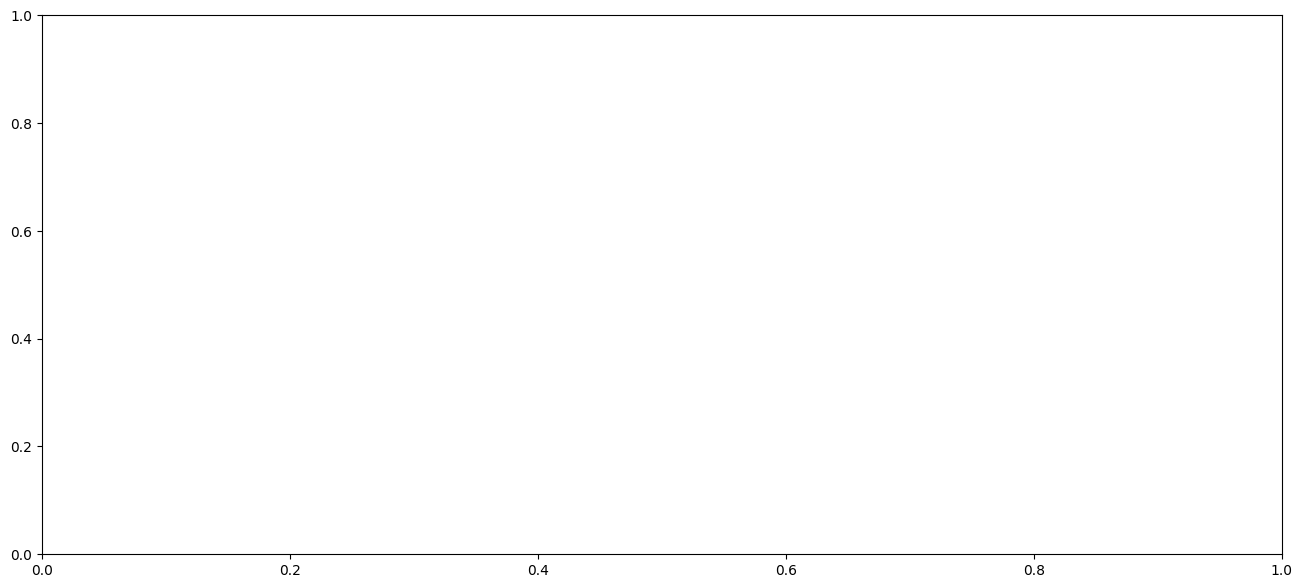

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Sample data (replace with your actual values)
ai_values = [precision_ai,recall_ai,f1_ai]
human_values = [precision_human,recall_human,f1_human]

# Metrics names
metrics = [ 'Precision', 'Recall', 'F1-Score']

# Number of metrics
num_metrics = len(metrics)

# Create an array of indices for each metric
indices = np.arange(num_metrics)

# Bar width
bar_width = 0.35

# Plotting
fig, ax = plt.subplots(figsize=(16, 7))

# Plot AI values
ax.bar(indices, ai_values, bar_width, label='AI', color='blue',alpha=0.5,width=0.3)

# Plot Human values
ax.bar(indices + bar_width, human_values, bar_width, label='Human', color='orange')

# Customize the plot
# Make the y-axis tick labels darker and bigger
ax.tick_params(axis='both', labelsize=20, labelcolor='black')

# Make the axis labels (x and y) bold
ax.xaxis.label.set_fontweight('bold')
ax.yaxis.label.set_fontweight('bold')
ax.set_xticks(indices + bar_width / 2)

ax.set_xticklabels(metrics)
ax.legend()
ax.set_ylabel('Metric Values',fontweight='bold')
#ax.set_title('Comparison of AI and Human Performance Metrics')

# Show the plot
plt.show()

<ipython-input-18-b620408bd474>:21: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(labels, fontweight='bold')


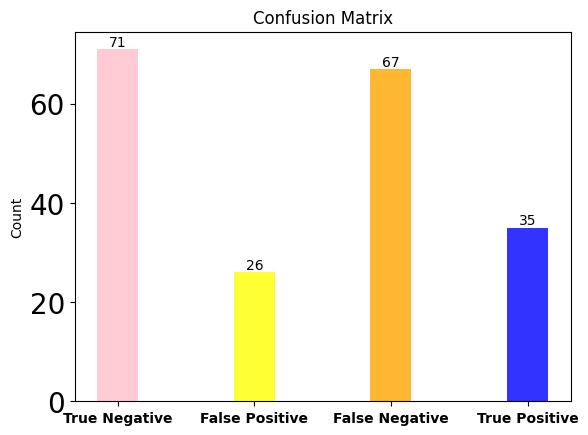

In [ ]:
# Extract values from confusion matrix
tn, fp, fn, tp = conf_matrix.ravel()

# Plotting
labels = ['True Negative', 'False Positive', 'False Negative', 'True Positive']
values = [tn, fp, fn, tp]

fig, ax = plt.subplots()
bars = ax.bar(labels, values, color=['pink', 'yellow', 'orange', 'blue'],alpha=0.8,width=0.3)

# Add labels and title
ax.set_ylabel('Count')
ax.set_title('Confusion Matrix')

# Add value annotations on top of the bars
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval, round(yval, 2), ha='center', va='bottom')

ax.tick_params(axis='y', labelsize=20, labelcolor='black')
ax.set_xticklabels(labels, fontweight='bold')

plt.show()